In [1]:
import numpy as np 
import pandas as pd 
import datetime, json, math

import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import matplotlib.pylab as plt
%matplotlib inline

## Load Data of COVID-19 

In [112]:
# load row data
# file path if the data is in the same folder as the notebook
row_data_path = r'RKI_COVID19.csv'
rki_covid_data = pd.read_csv(row_data_path)
rki_covid_data.head()

,ObjectId,IdBundesland,Bundesland,Landkreis,Altersgruppe,Geschlecht,AnzahlFall,AnzahlTodesfall,Meldedatum,IdLandkreis,Datenstand,NeuerFall,NeuerTodesfall,Refdatum,NeuGenesen,AnzahlGenesen,IstErkrankungsbeginn,Altersgruppe2
0,13519978,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,2020/03/14 00:00:00,1001,"22.06.2020, 00:00 Uhr",0,-9,2020/03/16 00:00:00,0,1,1,Nicht übermittelt
1,13519979,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,2020/03/19 00:00:00,1001,"22.06.2020, 00:00 Uhr",0,-9,2020/03/13 00:00:00,0,1,1,Nicht übermittelt
2,13519980,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,2020/03/19 00:00:00,1001,"22.06.2020, 00:00 Uhr",0,-9,2020/03/16 00:00:00,0,1,1,Nicht übermittelt
3,13519981,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,2020/03/21 00:00:00,1001,"22.06.2020, 00:00 Uhr",0,-9,2020/03/13 00:00:00,0,1,1,Nicht übermittelt
4,13519982,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,2020/03/27 00:00:00,1001,"22.06.2020, 00:00 Uhr",0,-9,2020/03/22 00:00:00,0,1,1,Nicht übermittelt


In [113]:
# create a column containing the date (Erkrankungsdatum bzw. wenn das nicht bekannt ist, das Meldedatum)
rki_covid_data["Date"] = pd.to_datetime(rki_covid_data['Refdatum'], format='%Y/%m/%d %H:%M:%S.%f')
rki_covid_data["Date"] = rki_covid_data['Date'].dt.date
rki_covid_data.head()

,ObjectId,IdBundesland,Bundesland,Landkreis,Altersgruppe,Geschlecht,AnzahlFall,AnzahlTodesfall,Meldedatum,IdLandkreis,Datenstand,NeuerFall,NeuerTodesfall,Refdatum,NeuGenesen,AnzahlGenesen,IstErkrankungsbeginn,Altersgruppe2,Date
0,13519978,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,2020/03/14 00:00:00,1001,"22.06.2020, 00:00 Uhr",0,-9,2020/03/16 00:00:00,0,1,1,Nicht übermittelt,2020-03-16
1,13519979,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,2020/03/19 00:00:00,1001,"22.06.2020, 00:00 Uhr",0,-9,2020/03/13 00:00:00,0,1,1,Nicht übermittelt,2020-03-13
2,13519980,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,2020/03/19 00:00:00,1001,"22.06.2020, 00:00 Uhr",0,-9,2020/03/16 00:00:00,0,1,1,Nicht übermittelt,2020-03-16
3,13519981,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,2020/03/21 00:00:00,1001,"22.06.2020, 00:00 Uhr",0,-9,2020/03/13 00:00:00,0,1,1,Nicht übermittelt,2020-03-13
4,13519982,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,2020/03/27 00:00:00,1001,"22.06.2020, 00:00 Uhr",0,-9,2020/03/22 00:00:00,0,1,1,Nicht übermittelt,2020-03-22


## Data pre-processing 

In [114]:
# structure table to be grouped by Bundesländer and sorted by Refdatum
iterables = [rki_covid_data["Bundesland"].unique(), pd.date_range(start=sorted(rki_covid_data["Date"])[0], end=sorted(rki_covid_data["Date"])[-1], freq='D')]
bund_date_index = pd.MultiIndex.from_product(iterables, names=['Bundesland', 'Date'])

In [115]:
# compute number of infections, deaths and recoveries per Bundesland per day
# NOT CUMULATIVE
cases_per_bund_per_day = rki_covid_data[rki_covid_data['NeuerFall'].isin([0,1])].groupby(["Bundesland", "Date"], as_index=True).AnzahlFall.sum()
deaths_per_bund_per_day = rki_covid_data[rki_covid_data['NeuerTodesfall'].isin([0,1])].groupby(["Bundesland", "Date"], as_index=True).AnzahlTodesfall.sum()
recovered_per_bund_per_day = rki_covid_data[rki_covid_data['NeuGenesen'].isin([0,1])].groupby(["Bundesland", "Date"], as_index=True).AnzahlGenesen.sum()
df_per_day = pd.DataFrame(index=bund_date_index)
df_per_day["AnzahlFall"] = cases_per_bund_per_day
df_per_day["AnzahlTodesfall"] = deaths_per_bund_per_day
df_per_day["AnzahlGenesen"] = recovered_per_bund_per_day
df_per_day.fillna(0,inplace=True)

In [116]:
df_per_day[490:500]

AnzahlFall  AnzahlTodesfall  AnzahlGenesen
Bundesland    Date                                                  
Niedersachsen 2020-05-24        42.0              1.0           41.0
              2020-05-25        66.0              0.0           66.0
              2020-05-26        59.0              1.0           36.0
              2020-05-27        88.0              0.0           46.0
              2020-05-28        54.0              0.0           27.0
              2020-05-29        54.0              1.0           35.0
              2020-05-30        49.0              0.0           31.0
              2020-05-31        34.0              0.0           22.0
              2020-06-01        62.0              0.0           48.0
              2020-06-02        69.0              0.0           48.0

In [117]:
# compute cumulative number of infections, deaths and recoveries per Bundesland per day
df_per_day["AnzahlFallCumul"] = df_per_day["AnzahlFall"].groupby("Bundesland", as_index=True).cumsum()
df_per_day["AnzahlTodesfallCumul"] = df_per_day["AnzahlTodesfall"].groupby("Bundesland", as_index=True).cumsum()
df_per_day["AnzahlGenesenCumul"] = df_per_day["AnzahlGenesen"].groupby("Bundesland", as_index=True).cumsum()

In [118]:
df_per_day[490:500]

AnzahlFall  AnzahlTodesfall  AnzahlGenesen  \
Bundesland    Date                                                     
Niedersachsen 2020-05-24        42.0              1.0           41.0   
              2020-05-25        66.0              0.0           66.0   
              2020-05-26        59.0              1.0           36.0   
              2020-05-27        88.0              0.0           46.0   
              2020-05-28        54.0              0.0           27.0   
              2020-05-29        54.0              1.0           35.0   
              2020-05-30        49.0              0.0           31.0   
              2020-05-31        34.0              0.0           22.0   
              2020-06-01        62.0              0.0           48.0   
              2020-06-02        69.0              0.0           48.0   

                          AnzahlFallCumul  AnzahlTodesfallCumul  \
Bundesland    Date                                                
Niedersachsen 2020-05-24          11833.0                 614.0   
              2020-05-25          11899.0                 614.0   
              2020-05-26          11958.0                 615.0   
              2020-05-27          12046.0                 615.0   
              2020-05-28          12100.0                 615.0   
              2020-05-29          12154.0                 616.0   
              2020-05-30          12203.0                 616.0   
              2020-05-31          12237.0                 616.0   
              2020-06-01          12299.0                 616.0   
              2020-06-02          12368.0                 616.0   

                          AnzahlGenesenCumul  
Bundesland    Date                            
Niedersachsen 2020-05-24             11217.0  
              2020-05-25             11283.0  
              2020-05-26             11319.0  
              2020-05-27             11365.0  
              2020-05-28             11392.0  
              2020-05-29             11427.0  
              2020-05-30             11458.0  
              2020-05-31             11480.0  
              2020-06-01             11528.0  
              2020-06-02             11576.0

In [119]:
# Data organizated by Bundesland
# Assemble complete number of cumulative infections, deaths and recoveries per Bundesland 
#(summed across the time range 1/1/2020 21/6/2020)
df_bl = pd.DataFrame()
df_bl = df_per_day.groupby("Bundesland", as_index=True).sum()
df_bl = df_bl.drop(columns = ["AnzahlFallCumul", "AnzahlTodesfallCumul", "AnzahlGenesenCumul"])
df_bl = df_bl.reset_index()
df_bl.head()

,Bundesland,AnzahlFall,AnzahlTodesfall,AnzahlGenesen
0,Baden-Württemberg,35272.0,1824.0,33100.0
1,Bayern,47867.0,2567.0,44678.0
2,Berlin,7833.0,211.0,6906.0
3,Brandenburg,3394.0,163.0,3142.0
4,Bremen,1648.0,49.0,1505.0


In [120]:
map_cases_per_day = df_per_day.reset_index()
map_cases_per_day['Date'] = map_cases_per_day["Date"].astype(str)
print(map_cases_per_day[90:100])

            Bundesland        Date  AnzahlFall  AnzahlTodesfall  \
90  Schleswig-Holstein  2020-03-31        60.0              5.0   
91  Schleswig-Holstein  2020-04-01        72.0              9.0   
92  Schleswig-Holstein  2020-04-02        46.0              0.0   
93  Schleswig-Holstein  2020-04-03        76.0              3.0   
94  Schleswig-Holstein  2020-04-04        53.0              3.0   
95  Schleswig-Holstein  2020-04-05        38.0              2.0   
96  Schleswig-Holstein  2020-04-06        50.0              7.0   
97  Schleswig-Holstein  2020-04-07        64.0              8.0   
98  Schleswig-Holstein  2020-04-08        57.0              3.0   
99  Schleswig-Holstein  2020-04-09        44.0              3.0   

    AnzahlGenesen  AnzahlFallCumul  AnzahlTodesfallCumul  AnzahlGenesenCumul  
90           55.0           1723.0                  60.0              1663.0  
91           63.0           1795.0                  69.0              1726.0  
92           46.0        

In [121]:
# round up the maximum number of given numbers
def roundup(num_array):
    num = round(max(num_array)) 
    return math.ceil(num/10 ** (len(str(num))-1)) * 10 ** (len(str(num))-1)

# max_infection = roundup(bl_total_infection['AnzahlFall']) 

## Load map of Germany from json file

In [4]:
# Data source: https://github.com/isellsoap/deutschlandGeoJSON/tree/master/2_bundeslaender
map_file = open("3_mittel.geo.json")
germany_map = json.load(map_file)

germany_map['features'][0]['properties']

{'id': 'DE-BW', 'name': 'Baden-Württemberg', 'type': 'State'}

In [122]:
# for Mac: to get around some encoding errors
# with open("3_mittel.geo.json", encoding="utf8", errors='ignore') as f:
#     germany_map = json.load(f)
# germany_map['features'][0]['properties']['name'] = 'Baden-Württemberg'
# germany_map['features'][15]['properties']['name'] = 'Thüringen'

## Choropleth map
In case of install error with psutil:
- pip3 install psutil
- conda install -c plotly plotly-orca

In [106]:
# examples of plotly maps: https://plotly.com/python/mapbox-county-choropleth/#data-indexed-by-id
max_infection = roundup(df_bl['AnzahlFall'])
fig = px.choropleth_mapbox(df_bl, geojson=germany_map, locations='Bundesland',
                           color='AnzahlFall',
                           featureidkey="properties.name",
                           color_continuous_scale='blues',
                           range_color=(0, max_infection),
                           center={"lat": 51, "lon": 9.65},
                           mapbox_style="carto-positron",
                           zoom=4, 
                           opacity=0.5,
                           labels={"Infection number in 16 Bundesländer"}
                          )
fig.write_image("choropleth_infection.jpg")

In [107]:
max_death = roundup(df_bl['AnzahlTodesfall'])
fig = px.choropleth_mapbox(df_bl, geojson=germany_map, locations='Bundesland',
                           color='AnzahlTodesfall',
                           featureidkey="properties.name", 
                           color_continuous_scale='reds',
                           range_color=(0, max_death),
                           center={"lat": 51, "lon": 9.65},
                           mapbox_style="carto-positron",
                           zoom=4, 
                           opacity=0.5,
                           labels={"Death number in 16 Bundesländer"}
                          )
fig.write_image("choropleth_death.jpg")

## Choropleth map over time

In [ ]:
fig = px.choropleth(map_cases_per_day, 
                    geojson=germany_map, 
                    locations='Bundesland',
                    color='AnzahlFallCumul',
                    featureidkey="properties.name", 
                    color_continuous_scale='blues',
                    animation_frame="Date",
                    scope="europe",
                    #center={"lat": 10, "lon": 10},
                    labels={"Infection number in 16 Bundesländer over time"},
                    )

fig.show()

In [ ]:
fig = px.choropleth(map_cases_per_day, 
                    geojson=germany_map, 
                    locations='Bundesland',
                    color='AnzahlTodesfallCumul',
                    featureidkey="properties.name", 
                    color_continuous_scale='reds',
                    animation_frame="Date",
                    scope="europe",
                    #center={"lat": 10, "lon": 10},
                    labels={"Death number in 16 Bundesländer over time"},
                    )

fig.show()

## Bubble map over time

In [123]:
# map the states to lat/long of their capital, from: https://latitudelongitude.org/de/
'''
Baden-Württemberg – Hauptstadt Stuttgart, 48.78232, 9.17702
Bayern – Hauptstadt München, 48.13743, 11.57549
Berlin – Hauptstadt Berlin, 52.52437, 13.41053 ...
'''
capital_dict = {'Schleswig-Holstein': (54.32133, 10.13489), 'Hamburg':(53.57532, 10.01534), 'Niedersachsen':(52.37052, 9.73322),
                'Bremen':(53.07516, 8.80777), 'Nordrhein-Westfalen':(51.22172, 6.77616), 'Hessen':(50.08258, 8.24932), 
                'Rheinland-Pfalz':(49.98419, 8.2791), 'Baden-Württemberg':(48.78232, 9.17702), 'Bayern':(48.13743, 11.57549), 
                'Saarland':(49.2354, 6.98165), 'Berlin':(52.52437, 13.41053), 'Brandenburg':(52.39886, 13.06566),
                'Mecklenburg-Vorpommern':(53.62937, 11.41316), 'Sachsen':(51.05089, 13.73832), 'Sachsen-Anhalt':(52.12773, 11.62916), 
                'Thüringen':(50.9787, 11.03283)}
lat = [capital_dict[bund][0] for bund in map_cases_per_day["Bundesland"].unique() for i in range(len(iterables[1]))]
long = [capital_dict[bund][1] for bund in map_cases_per_day["Bundesland"].unique() for i in range(len(iterables[1]))]

map_cases_per_day["lat"] = lat
map_cases_per_day["long"] = long
map_cases_per_day.head()

,Bundesland,Date,AnzahlFall,AnzahlTodesfall,AnzahlGenesen,AnzahlFallCumul,AnzahlTodesfallCumul,AnzahlGenesenCumul,lat,long
0,Schleswig-Holstein,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,54.32133,10.13489
1,Schleswig-Holstein,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,54.32133,10.13489
2,Schleswig-Holstein,2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,54.32133,10.13489
3,Schleswig-Holstein,2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,54.32133,10.13489
4,Schleswig-Holstein,2020-01-05,0.0,0.0,0.0,0.0,0.0,0.0,54.32133,10.13489


In [ ]:
fig = px.scatter_geo(map_cases_per_day, color="AnzahlFallCumul",
                     hover_name="Bundesland", size="AnzahlFallCumul",
                     lat="lat",
                     lon="long",
                     color_continuous_scale='blues',
                     animation_frame="Date",
                     scope="europe",
                     #center={"lat": 10, "lon": 10},
                     # projection="natural earth",
                     title="Infection number in 16 Bundesländer over time",)
fig.show()

In [ ]:
fig = px.scatter_geo(map_cases_per_day, color="AnzahlTodesfallCumul",
                     hover_name="Bundesland", size="AnzahlTodesfallCumul",
                     lat="lat",
                     lon="long",
                     color_continuous_scale='reds',
                     animation_frame="Date",
                     scope="europe",
                     #center={"lat": 10, "lon": 10},
                     # projection="natural earth",
                     title="Death number in 16 Bundesländer over time",)
fig.show()

## Bar Chart

In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(name='AnzahlFall', y=df_bl.loc[:, 'Bundesland'], x=df_bl.loc[:, 'AnzahlFall'], orientation='h'))
fig.add_trace(go.Bar(name='AnzahlTodesfall', y=df_bl.loc[:, 'Bundesland'], x=df_bl.loc[:, 'AnzahlTodesfall'], orientation='h'))
fig.add_trace(go.Bar(name='AnzahlGenesen', y=df_bl.loc[:, 'Bundesland'], x=df_bl.loc[:, 'AnzahlGenesen'], orientation='h'))

fig.update_layout(barmode='group', title='Comparative case analysis of 16 Bundesländer in Germany')
fig.show()

In [21]:
# Number of 16 Bundesländer in Germany to which COVID-19 spread over the time

def newInfectedLand(df_per_day):
    land_count = df_per_day['AnzahlFall'].groupby(["Date", "Bundesland"]).sum() 
    land_count = land_count.reset_index()
    
    d = land_count["Date"].unique()
    len_b = len(land_count["Bundesland"].unique())
    
    new_infected_date = [len_b] * len(d)
    new_infected_land = set()

    for i in range(len(d)):
        if len(new_infected_land) == len_b:
            break
        new_list = land_count["Bundesland"][(land_count["Date"] == d[i]) & (land_count["AnzahlFall"] > 0)].values
        for new_land in new_list:
            new_infected_land.add(new_land)

        new_infected_date[i] = len(new_infected_land)

    print(new_infected_date)
    
    return new_infected_date
    
new_infected_date = newInfectedLand(df_per_day)

[1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 6, 10, 10, 11, 12, 12, 12, 13, 13, 13, 13, 13, 13, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]


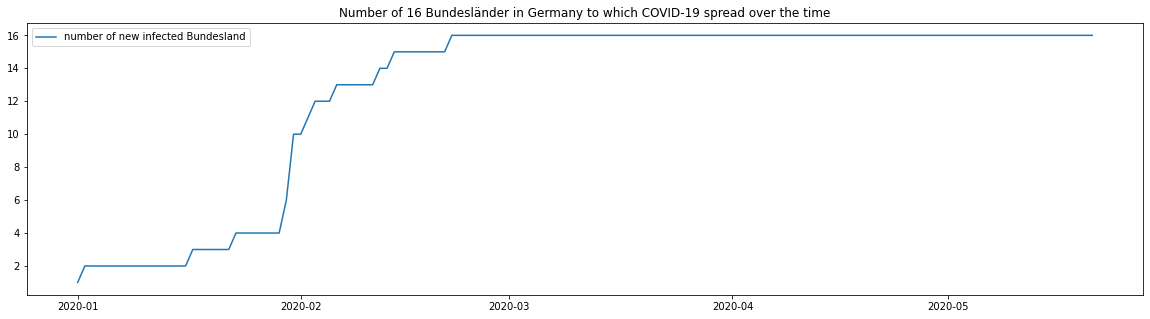

In [22]:
plt.figure(figsize=(20,5))
x=iterables[1].values
y=new_infected_date
plt.plot(x, y, label= 'number of new infected Bundesland')
plt.title("Number of 16 Bundesländer in Germany to which COVID-19 spread over the time")
plt.legend()
plt.show()

In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(name='AnzahlFall', y=df_bl.loc[:, 'Bundesland'], x=df_bl.loc[:, 'AnzahlFall'], orientation='h'))
fig.add_trace(go.Bar(name='AnzahlTodesfall', y=df_bl.loc[:, 'Bundesland'], x=df_bl.loc[:, 'AnzahlTodesfall'], orientation='h'))
fig.add_trace(go.Bar(name='AnzahlGenesen', y=df_bl.loc[:, 'Bundesland'], x=df_bl.loc[:, 'AnzahlGenesen'], orientation='h'))

fig.update_layout(barmode='stack', title='Number of Confirmed/Death/Recovered Cases in Germany')
fig.show()

In [24]:
# Data organizated by date 
df_date = df_per_day.groupby("Date").sum()
df_date = df_date.reset_index()
df_date[90:100]

,Date,AnzahlFall,AnzahlTodesfall,AnzahlGenesen,AnzahlFallCumul,AnzahlTodesfallCumul,AnzahlGenesenCumul
90,2020-03-31,4010.0,261.0,3749.0,96433.0,3551.0,92880.0
91,2020-04-01,4514.0,285.0,4228.0,100947.0,3836.0,97108.0
92,2020-04-02,4348.0,330.0,4015.0,105295.0,4166.0,101123.0
93,2020-04-03,4557.0,341.0,4215.0,109852.0,4507.0,105338.0
94,2020-04-04,3321.0,221.0,3100.0,113173.0,4728.0,108438.0
95,2020-04-05,2611.0,186.0,2425.0,115784.0,4914.0,110863.0
96,2020-04-06,3505.0,272.0,3230.0,119289.0,5186.0,114093.0
97,2020-04-07,3529.0,244.0,3285.0,122818.0,5430.0,117378.0
98,2020-04-08,3543.0,248.0,3293.0,126361.0,5678.0,120671.0
99,2020-04-09,3362.0,229.0,3129.0,129723.0,5907.0,123800.0


In [ ]:
# Number of Confirmed, Death and Recovered Cases in Germany
fig = go.Figure()

fig = px.bar(df_date, y="AnzahlFallCumul", x="Date", color="AnzahlFallCumul", 
             color_continuous_scale='blues', hover_name="AnzahlFallCumul")
fig.update_yaxes(title_text='Confirmed')
fig.update_layout(title='Number of Confirmed cases in Germany')
fig.show()

In [ ]:
fig = go.Figure()

fig = px.bar(df_date, y="AnzahlTodesfallCumul", x="Date", color="AnzahlTodesfallCumul", 
             color_continuous_scale='reds', hover_name="AnzahlTodesfallCumul")
fig.update_yaxes(title_text='Death')
fig.update_layout(title='Number of Death cases in Germany')
fig.show()

In [ ]:
fig = go.Figure()

fig = px.bar(df_date, y="AnzahlGenesenCumul", x="Date", color="AnzahlGenesenCumul", 
             color_continuous_scale='greens', hover_name="AnzahlGenesenCumul")
fig.update_yaxes(title_text='Recovered')
fig.update_layout(title='Number of Recovered cases in Germany')
fig.show()

In [ ]:
fig = make_subplots(rows=1, cols=3, shared_xaxes=True, shared_yaxes=True, start_cell="bottom-left", y_title='Number of cases', x_title='Date', column_titles=["Confirmed", "Death", "Recovered"])

fig.add_trace(go.Bar(name="Confirmed", y=df_date["AnzahlFallCumul"], x=df_date["Date"]),
              row=1, col=1)
fig.add_trace(go.Bar(name="Death", y=df_date["AnzahlTodesfallCumul"], x=df_date["Date"]),
              row=1, col=2) 
fig.add_trace(go.Bar(name="Recovered", y=df_date["AnzahlGenesenCumul"], x=df_date["Date"]),
              row=1, col=3)

fig.update_layout(title='Number of Confirmed/Death/Recovered cases in Germany')
fig.show()

## Tree Map

In [ ]:
fig = px.treemap(df_bl, path=['Bundesland'], values='AnzahlFall')
fig.update_layout(title='Number of Confirmed cases in 16 Bundesländer')
fig.show()

In [ ]:
fig = px.treemap(df_bl, path=['Bundesland'], values='AnzahlTodesfall')
fig.update_layout(title='Number of Death cases in 16 Bundesländer')
fig.show()

In [ ]:
fig = px.treemap(df_bl, path=['Bundesland'], values='AnzahlGenesen')
fig.update_layout(title='Number of Recovered cases in 16 Bundesländer')
fig.show()

# Changepoint Analysis

In [ ]:
import sys
!{sys.executable} -m pip install ruptures
# either one of these
!{sys.executable} -m pip install changefinder
#!pip3 install changefinder

In [ ]:
import ruptures as rpt
import changefinder

In [36]:
def plot_changepoint_analysis_offline(bl_per_day, bl):
    # taken from here: https://techrando.com/2019/08/14/a-brief-introduction-to-change-point-detection-using-python/
    #Convert the time series values to a numpy 1D array
    points=np.array(bl_per_day)
    x_loc = np.arange(len(bl_per_day.index),step=20)
    x_desc = bl_per_day.index.astype(str)[::20]

    #RUPTURES PACKAGE
    #Changepoint detection with the Pelt search method
    model="rbf"
    algo = rpt.Pelt(model=model).fit(points)
    result = algo.predict(pen=10)
    rpt.display(points, result, figsize=(10, 2))
    plt.title('{}, Change Point Detection: Pelt Search Method'.format(bl))
    plt.xticks(x_loc, x_desc)
    plt.show() 

    #Changepoint detection with the Binary Segmentation search method
    model = "l2"  
    algo = rpt.Binseg(model=model, min_size=3, jump=5).fit(points)
    my_bkps = algo.predict(n_bkps=10)
    rpt.show.display(points, my_bkps, figsize=(10, 2))
    plt.title('{}, Change Point Detection: Binary Segmentation Search Method'.format(bl))
    plt.xticks(x_loc, x_desc)
    plt.show()

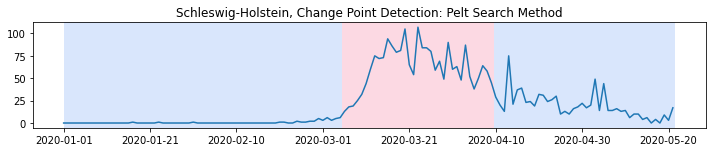

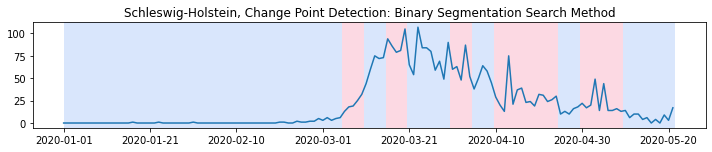

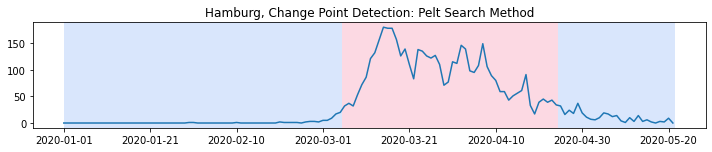

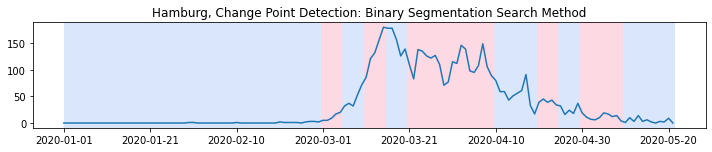

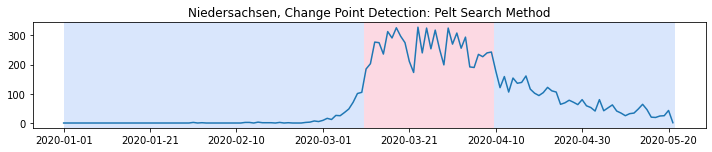

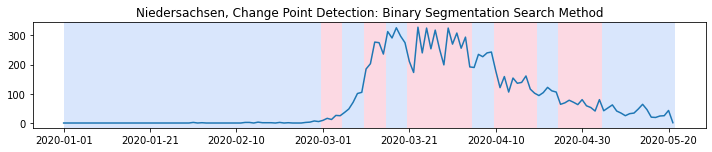

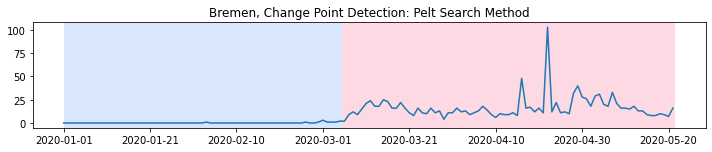

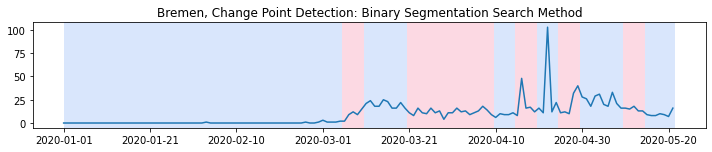

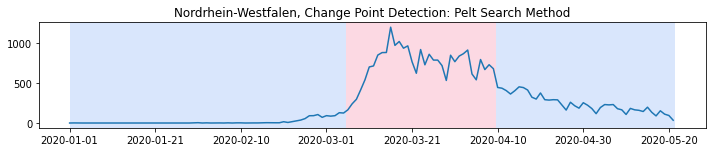

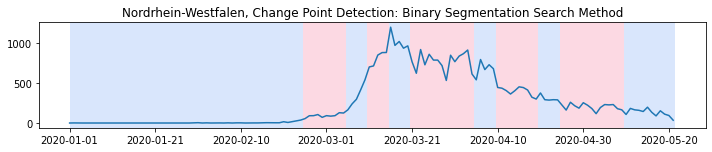

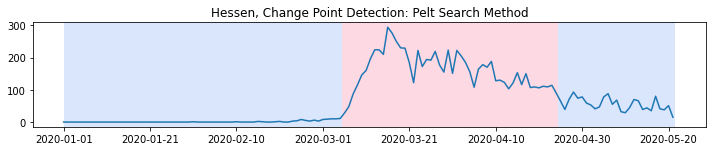

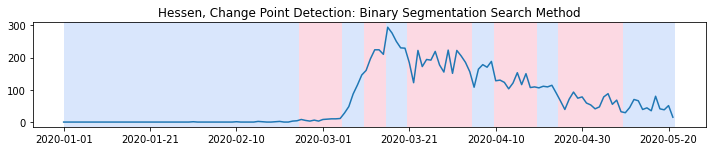

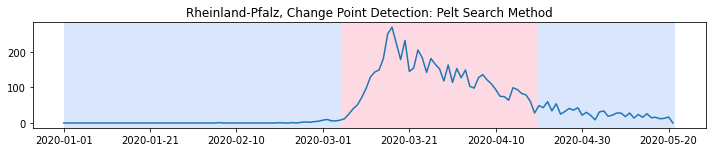

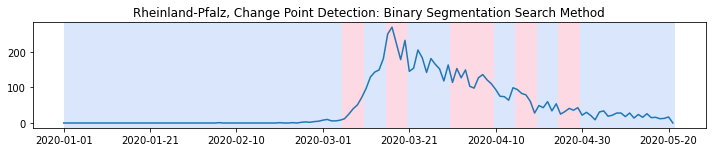

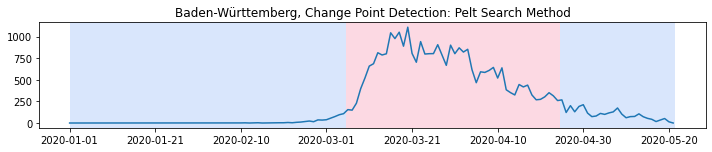

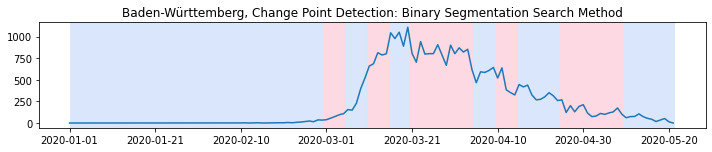

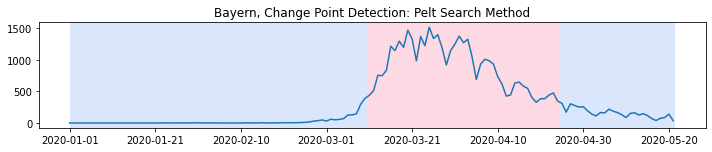

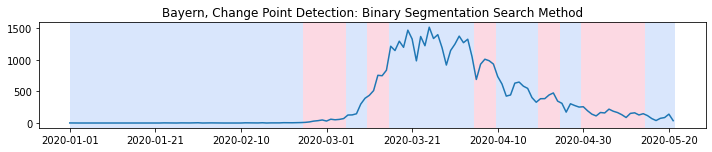

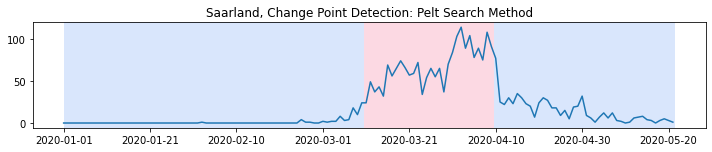

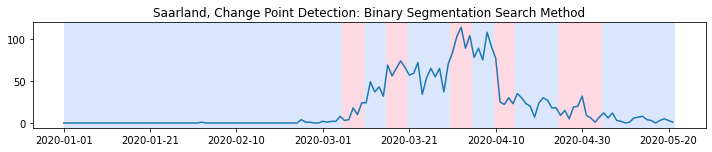

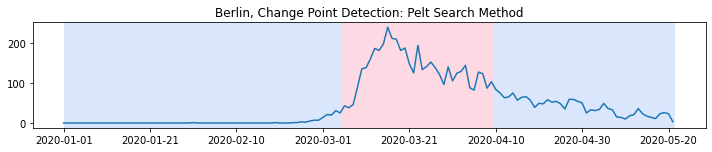

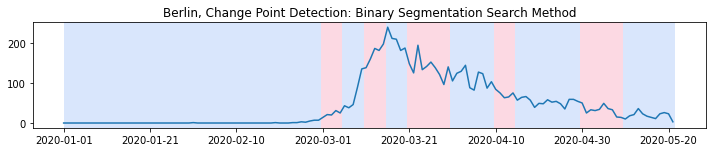

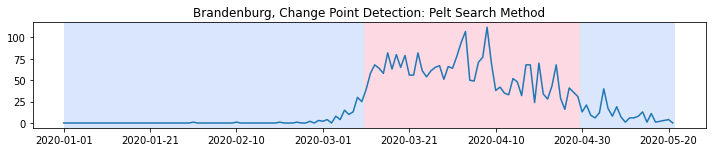

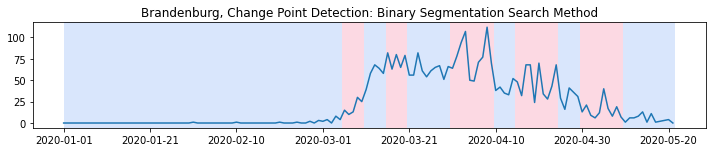

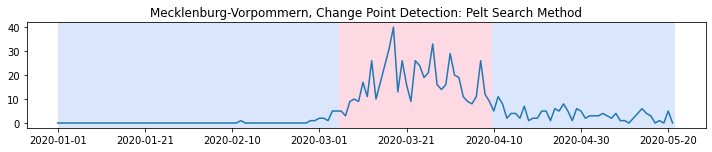

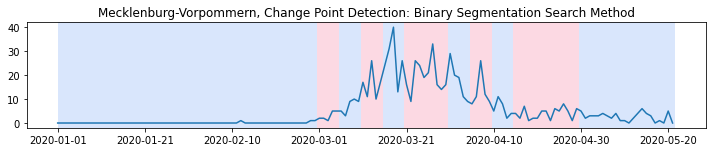

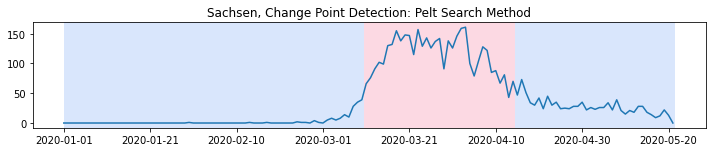

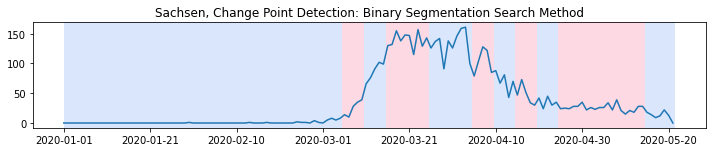

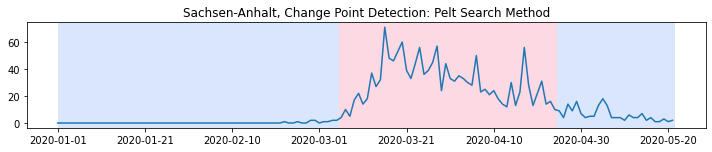

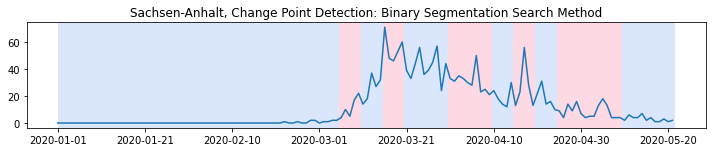

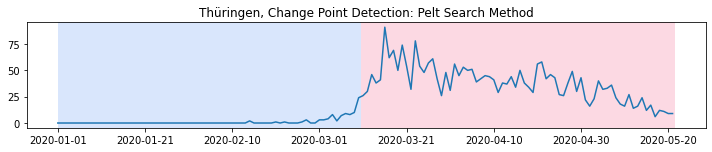

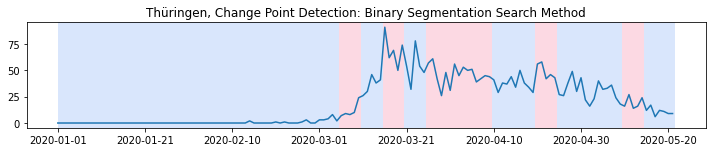

In [37]:
# each change in colour from blue to red or vice versa corresponds to a significant search point for the used search method
for bl in df_per_day.index.get_level_values(0).unique():
    bl_per_day = df_per_day["AnzahlFall"][bl]
    plot_changepoint_analysis_offline(bl_per_day, bl)

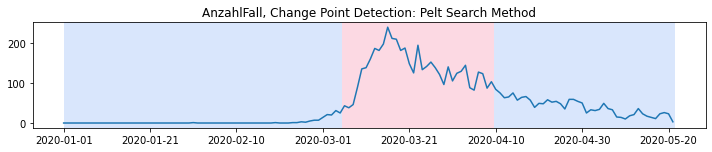

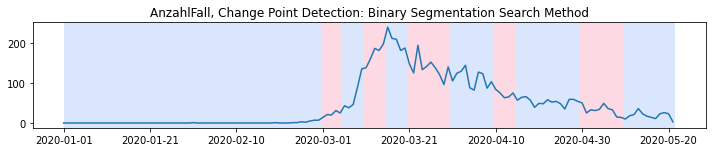

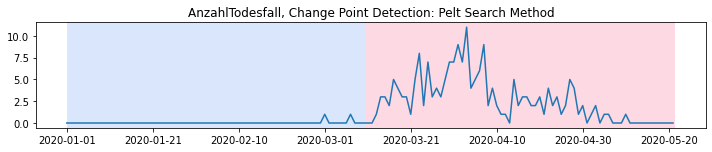

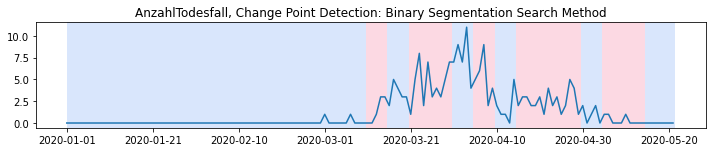

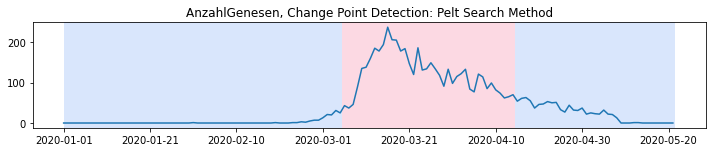

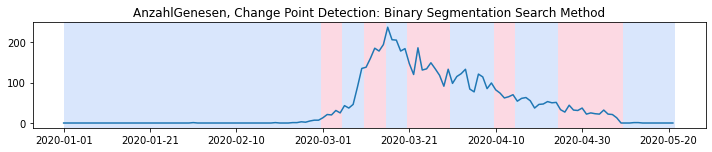

In [38]:
# each change in colour from blue to red or vice versa corresponds to a significant search point for the used search method
for fall in ["AnzahlFall", "AnzahlTodesfall", "AnzahlGenesen"]:
    bl_per_day = df_per_day[fall]["Berlin"]
    plot_changepoint_analysis_offline(bl_per_day, fall)

In [39]:
def plot_changepoint_analysis_online(points, bl):
    f, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))
    f.subplots_adjust(hspace=0.4)
    ax1.plot(points)
    ax1.set_title("data points: {}".format(bl))
    #Initiate changefinder function
    cf = changefinder.ChangeFinder()
    scores = [cf.update(p) for p in points]
    ax2.plot(points.index, scores)
    ax2.set_title("anomaly score: {}".format(bl))
    # plt.xticks(x_loc, x_desc)
    plt.show() 

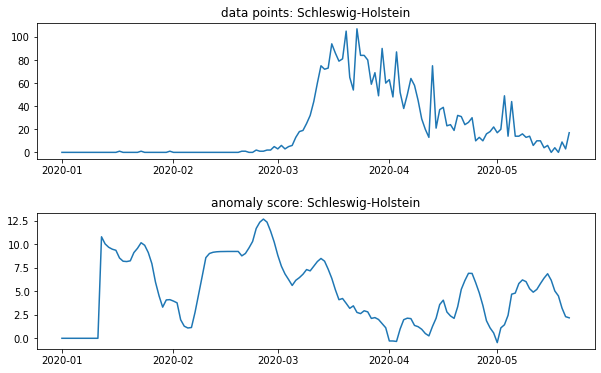

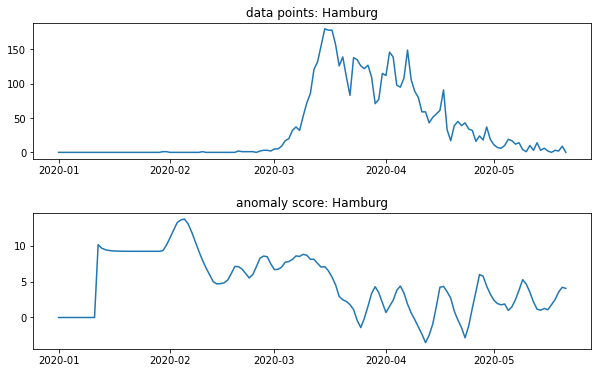

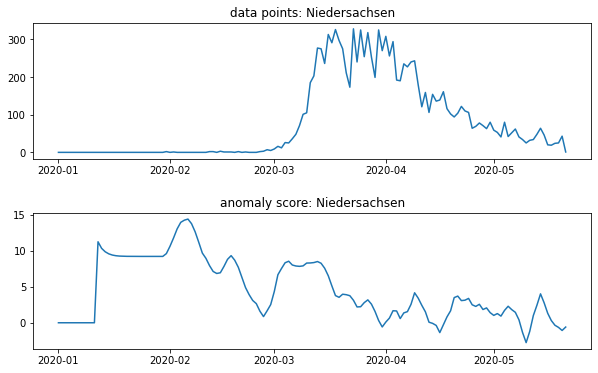

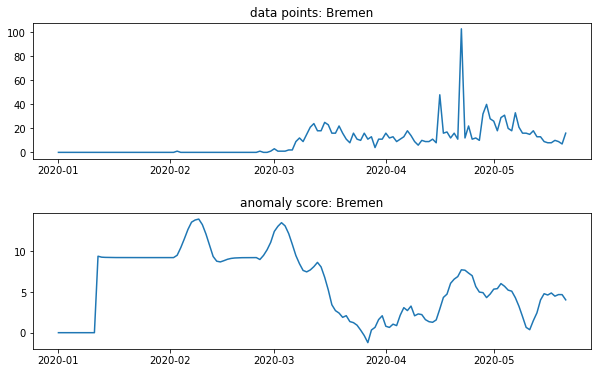

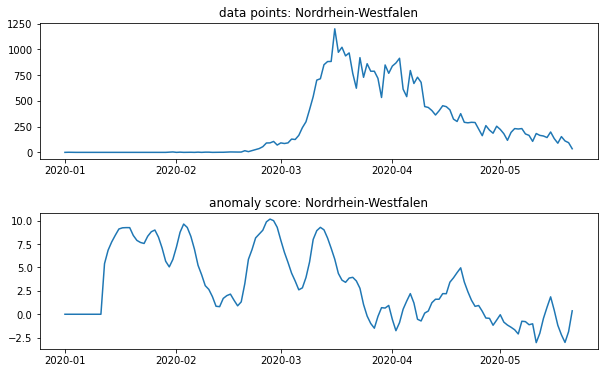

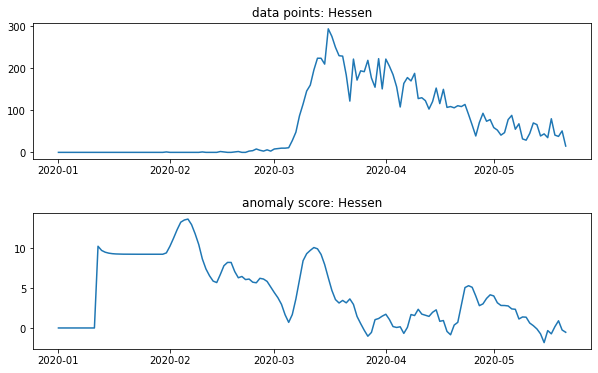

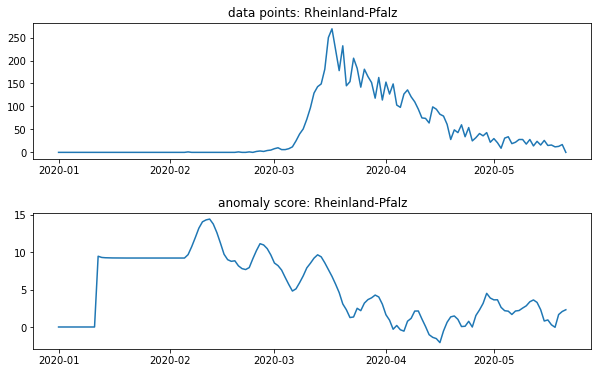

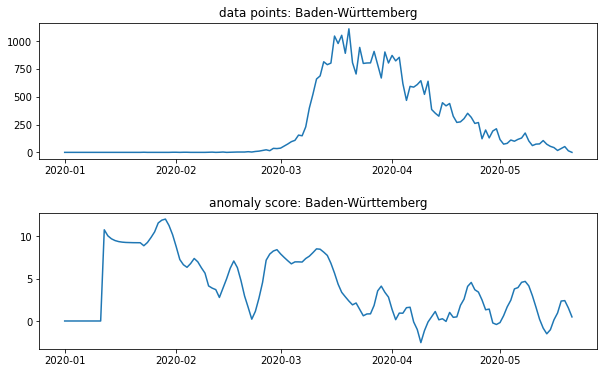

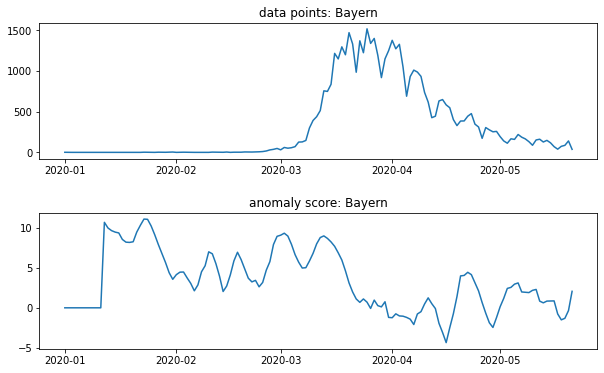

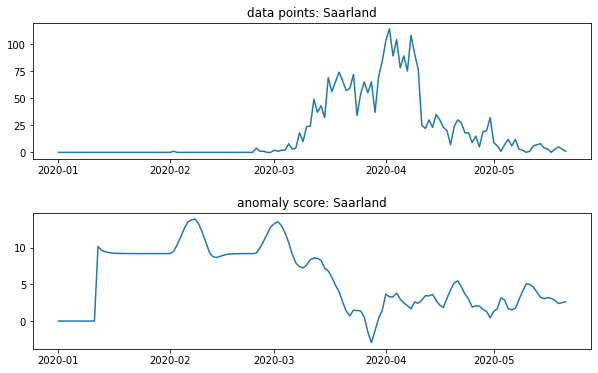

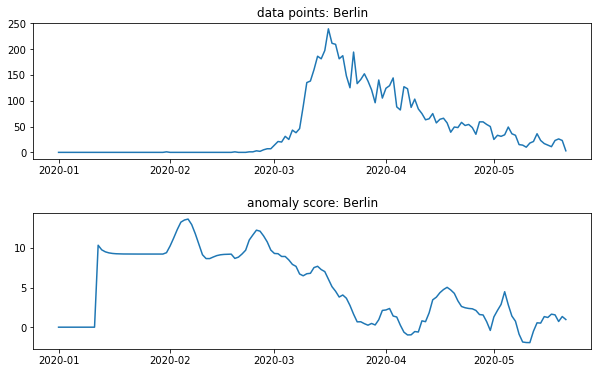

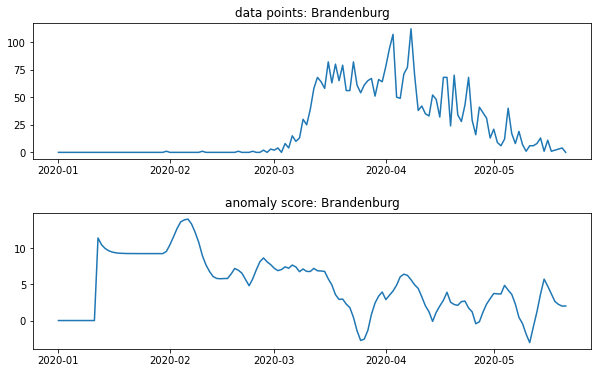

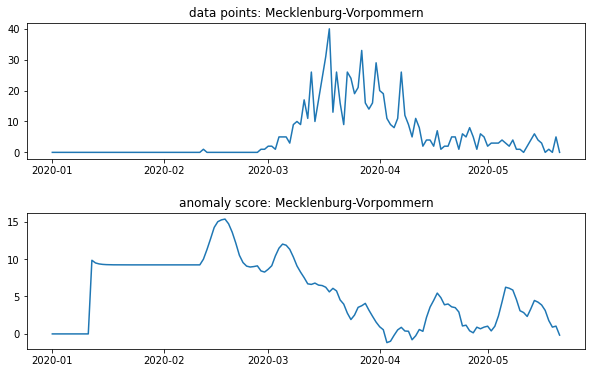

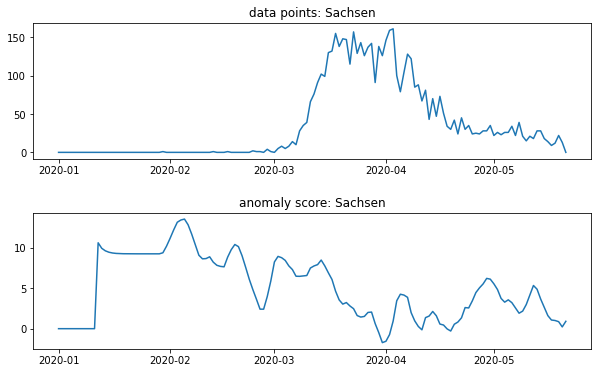

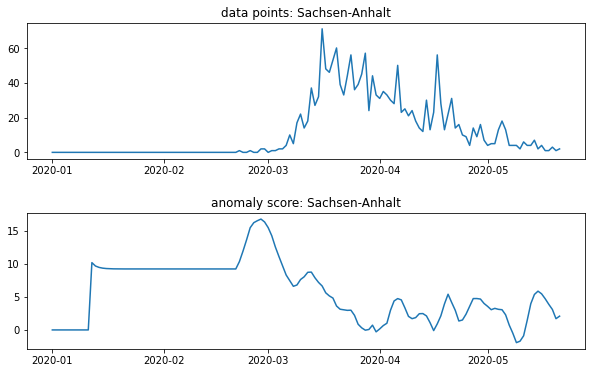

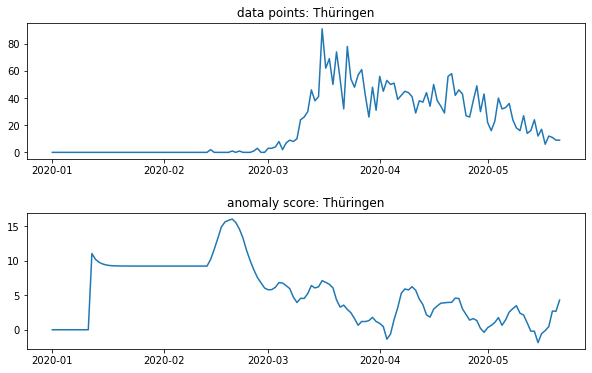

In [40]:
# the maxima of the anomaly score correspond to the points with the largest anomaly to previous time points
for bl in df_per_day.index.get_level_values(0).unique():
    bl_per_day = df_per_day["AnzahlFall"][bl]
    plot_changepoint_analysis_online(bl_per_day, bl)